1.Load and prepare a dataset for binary classification.

In [1]:
import pandas as pd

In [5]:
# Load dataset and check info
df = pd.read_csv("breast-cancer.csv")
print(df.head())
print(df.info())

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

EDA

In [8]:
print("Shape of dataset:", df.shape) 

Shape of dataset: (569, 32)


In [10]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


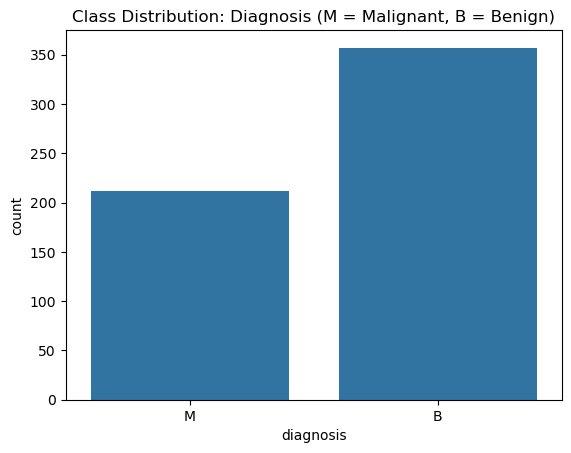

In [12]:
# Class Distribution

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='diagnosis')
plt.title("Class Distribution: Diagnosis (M = Malignant, B = Benign)")
plt.show()

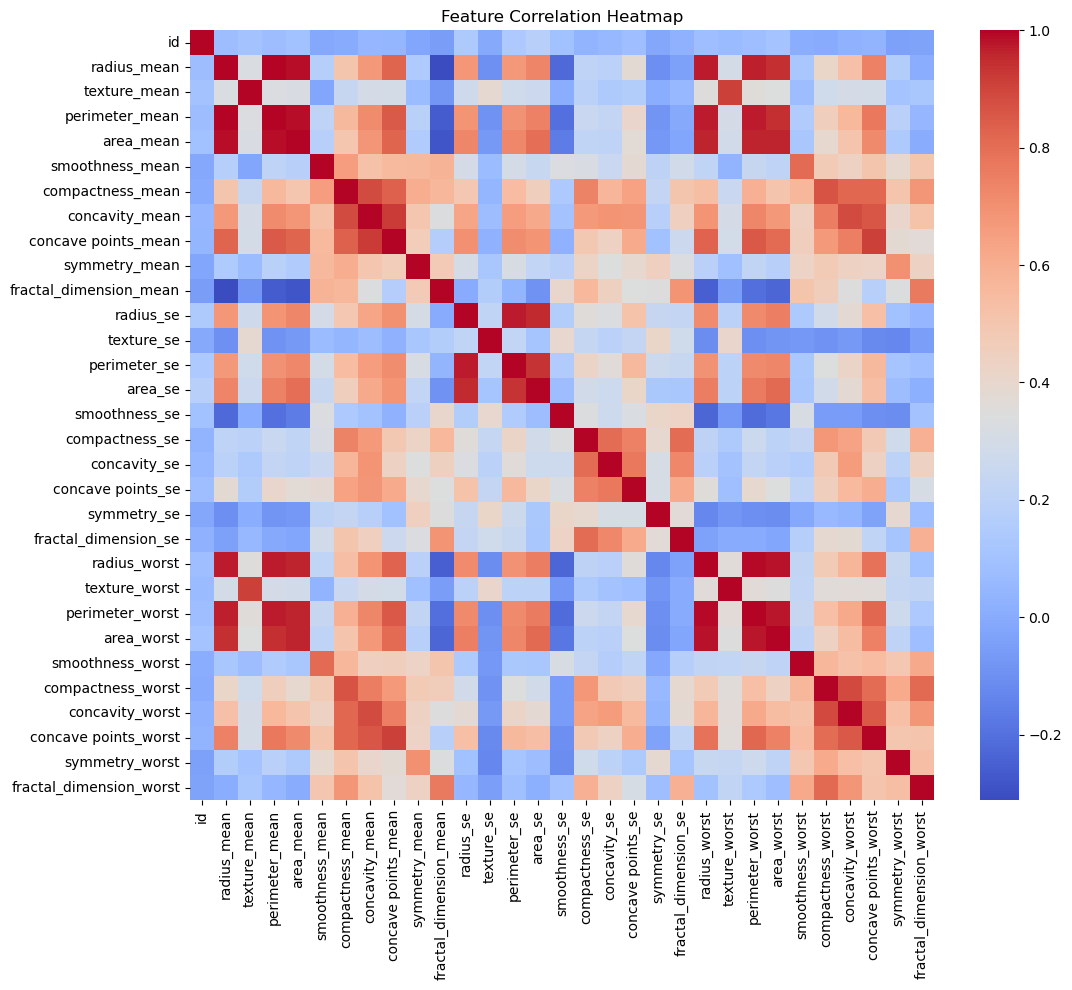

In [14]:
# Correlation heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

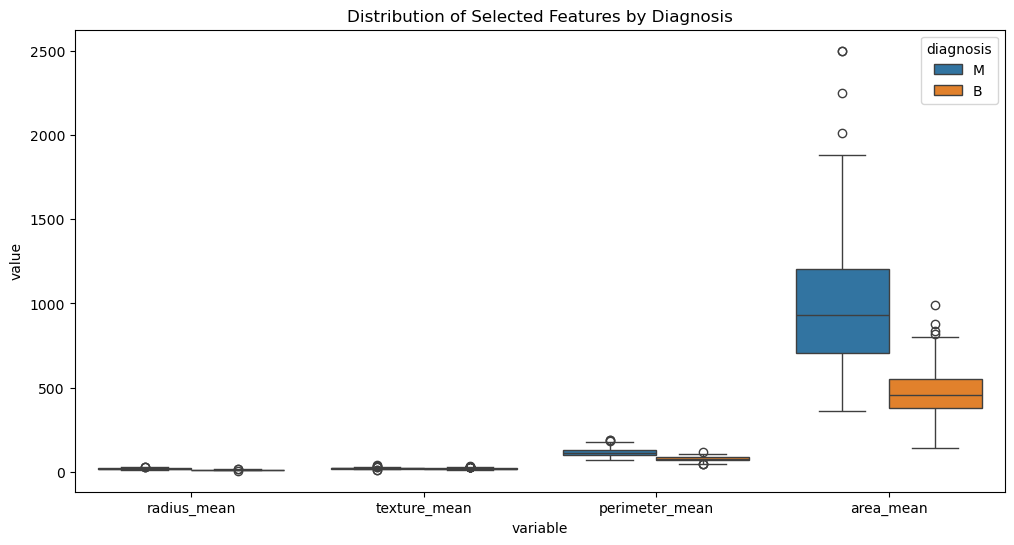

In [16]:
# Boxplots for some features
features = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean']
df_melted = pd.melt(df, id_vars='diagnosis', value_vars=features)

plt.figure(figsize=(12,6))
sns.boxplot(x='variable', y='value', hue='diagnosis', data=df_melted)
plt.title("Distribution of Selected Features by Diagnosis")
plt.show()

Data Preprocessing

In [19]:
# Drop non-informative column (ID, etc.)
df = df.drop(columns=["id", "Unnamed: 32"], errors="ignore")

In [21]:
# Encode target
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

In [23]:
# Features and target
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

In [25]:
# Standardize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

2.Train an SVM with linear and RBF kernel.

In [29]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Linear Kernel
svm_linear = SVC(kernel='linear')
svm_linear.fit(X_train, y_train)
y_pred_linear = svm_linear.predict(X_test)

print("Linear Kernel Report:")
print(classification_report(y_test, y_pred_linear))

# RBF Kernel
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X_train, y_train)
y_pred_rbf = svm_rbf.predict(X_test)

print("RBF Kernel Report:")
print(classification_report(y_test, y_pred_rbf))

Linear Kernel Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96        71
           1       0.93      0.95      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114

RBF Kernel Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



3.Visualize decision boundary using 2D data.

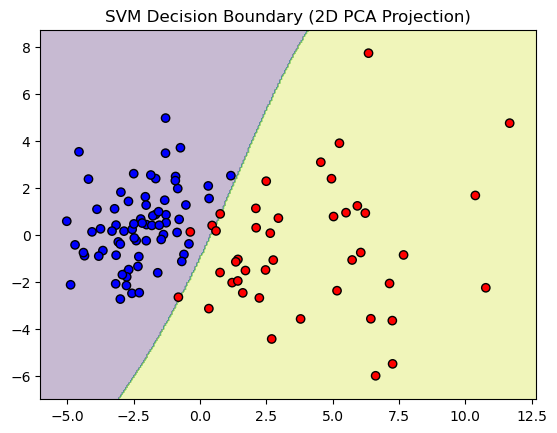

In [32]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(X_scaled)
X_train2D, X_test2D, y_train2D, y_test2D = train_test_split(X_pca, y, test_size=0.2, random_state=42)

clf = SVC(kernel='rbf', C=1, gamma=0.01)
clf.fit(X_train2D, y_train2D)

# Plot decision boundary
import numpy as np

def plot_decision_boundary(X, y, model):
    x_min, x_max = X[:, 0].min()-1, X[:, 0].max()+1
    y_min, y_max = X[:, 1].min()-1, X[:, 1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k')
    plt.title("SVM Decision Boundary (2D PCA Projection)")
    plt.show()

plot_decision_boundary(X_test2D, y_test2D, clf)

4.Tune hyperparameters like C and gamma.

In [35]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=1, cv=5)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Estimator:", grid.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Estimator: SVC(C=1)


5.Use cross-validation to evaluate performance.

In [38]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(grid.best_estimator_, X_scaled, y, cv=5)
print("Cross-validation Accuracy Scores:", scores)
print("Mean Accuracy: {:.2f}%".format(scores.mean() * 100))

Cross-validation Accuracy Scores: [0.97368421 0.95614035 1.         0.96491228 0.97345133]
Mean Accuracy: 97.36%
